# Практика 2


  -


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

In [218]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [3]:
data = load_iris()
X, y = data.data, data.target

In [4]:
X[0, :]

array([5.1, 3.5, 1.4, 0.2])

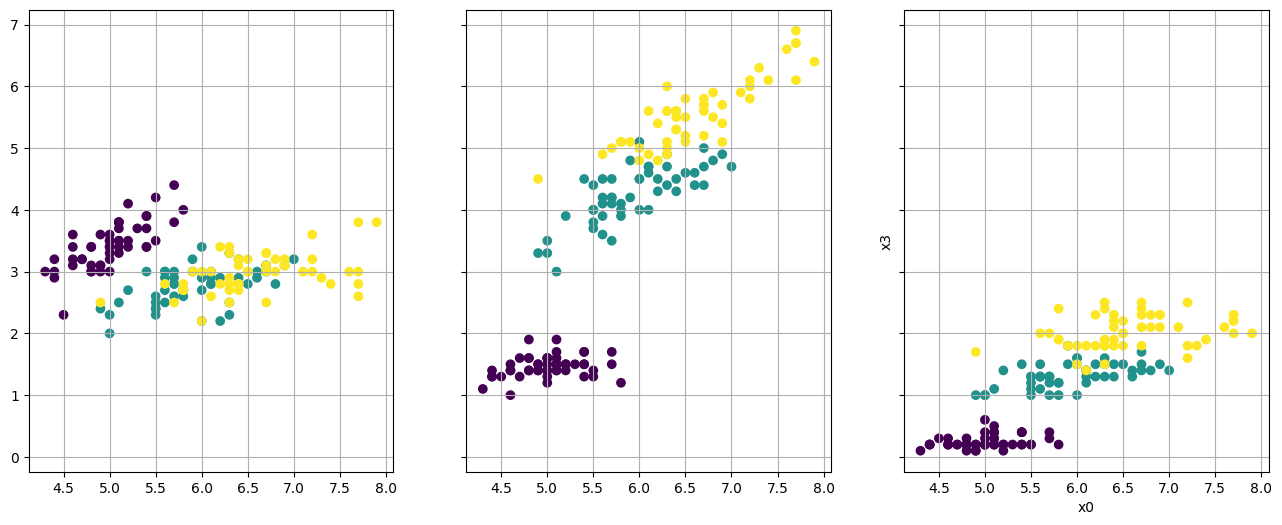

In [5]:
f, axes = plt.subplots(1, 3, sharey=True, figsize=(16, 6))
for i in range(1,4):
    axes[i-1].scatter(X[:, 0], X[:, i], c=y)
    axes[i-1].grid()

plt.xlabel('x0')
plt.ylabel('x'+str(i))
plt.show()

Посмотрим на соотношение классов в выборке, видим, что  поровну .

In [6]:
np.bincount(y)

array([50, 50, 50])

Выделим 70% выборки (X_train, y_train) под обучение и 30% будут отложенной выборкой (X_holdout, y_holdout). отложенная выборка никак не будет участвовать в настройке параметров моделей, на ней мы в конце, после этой настройки, оценим качество полученной модели.

In [10]:
# разбиение данных на тренировочные и отложенную выборку (тестовые),
#где X, y - описание примеров и их целевое свойство (классы), а test_size=0.3 - пропорция разбиения (доля тестов)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)

Обучим логистическую регрессию.

In [11]:
lr = LogisticRegression()

In [12]:
%%time
lr.fit(X_train, y_train)

CPU times: user 9.26 ms, sys: 8.56 ms, total: 17.8 ms
Wall time: 56.7 ms


LogisticRegression()

Сделаем прогнозы для отложенной выборки. Видим, что логрег справился неплохо.

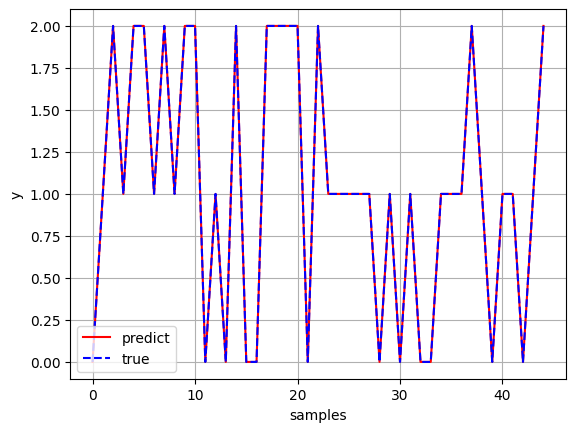

In [13]:
lr_pred = lr.predict(X_holdout)
plt.plot(lr_pred,'r', label = 'predict')
plt.plot(y_holdout,'--b', label = 'true')
plt.grid()
plt.legend()
plt.xlabel('samples')
plt.ylabel('y')
plt.show()

# Метрики

## Оценка качества классификации

Множество точек $\left \langle a(x_{i}) \right \rangle = 0$ образует _гиперповерхность_ в пространстве признаков и делит его на две части. Объекты, расположенние по разные стороны от нее, относятся к разным классам.

Соответственно, при классификации нам важен не только знак скалярного, но и  значение: чем выше оно, тем больше будет расстояние от объекта до разделяющей гиперпповерхности, что будет означать, что алгоритм более уверен в отнесении объекта к данному классу. Это приводит нас к значению _отступа_, который равен скалярному произведению вектора весов $w$ на вектор признаков $x$, умноженному на истинное значение ответа $y$, которое, как мы помним, принимает значения -1 и 1:

$$M_{i}=y_{i}\left \langle a(x_{i}) \right \rangle.$$

Таким образом, если скалярное произведение отрицательно, и истинный ответ равен -1, отступ будет больше нуля. Если скалярное произведение положительно, и истинный ответ равен 1, отступ также будет положителен. То есть $M_{i}>0$, когда классификатор дает верный ответ, и $M_{i}<0$, когда классификатор ошибается. Отступ характеризует корректность ответа, а его абсолютное значение свидетельствует о расстоянии от разделяющей гиперплоскости, то есть о мере уверенности в ответе.

В задачах классификации требуется оценивать качество обученной модели. Для этого существует большое количество подходов.

Наиболее очевидным и простым способом является расчет _доли правильных ответов_:

$$accuracy(a,x) = \frac{1}{l} \sum^{l}_{i=1}[a(x_{i})=y_{i}].$$

Эта метрика, однако, имеет определенные недостатки:

- Она может неадекватно работать на несбалансированных выборках, в которых объектов одного класса намного больше остальных: например, если у нас имеется выборка с 950 объектами класса +1 и 50 класса -1, обыкновенная константная модель классификатора, которая на всех объектах отдает ответ +1, будет иметь долю правильных ответов 0,95, при этом сам классификатор является абсолютно бесполезным. Методом борьбы с этим заключается в введении коэффициента $q_{0}$, равного доле объектов самого большого класса. Доля правильных ответов для корректных алгоритмов должна лежать в промежутке $[q_{0}, 1]$

- Она не учитывает "цены ошибок". В некоторых прикладных задачах ошибки разного рода могут иметь разную важность. Например, если говорить о кредитном скоринге, при постановке задачи необходимо определить, какая ошибка будет хуже: выдать кредит "плохому" клиенту или не выдать "хорошему". При этом используемая метрика качества должна учитывать цены разных ошибок.


### Матрица ошибок


Удобно представлять ответы в виде комбинации истинного ответа и ответа алгоритма. При этом получается так называемая _матрица ошибок_.

|  <empty>   | $$y = +1$$ | $$y = -1$$ |
--- | --- | ---
| __$$a(x) = +1$$__  |   TP    |   FP   |
| __$$a(x) = -1$$__ |   FN    |   TN   |
    
В матрице сверху отложены истинные ответы, слева - ответы алгоритма. Когда алгоритм относит объект к классу "+1", говорят, что он _срабатывает_, а когда к "-1", - _пропускает_. Если алгоритм сработал (дал положительный ответ) и объект действительно относится к классу "+1", говорят, что имеет место верное срабатывание/верный положительный ответ (True Positive, TP), а если объект не относится к классу "+1", это ложное срабатывание (False Positive, FP). Если алгоритм пропускает объект, а его истинный класс "+1", это ложный пропуск/ложный негативные ответ (False Negative, FN), а если истинный класс объекта "-1", имеет место истинный пропуск (True Negative, TN). При такой классификации уже есть два вида ошибок - ложные срабатывания и ложные пропуски. По главной диагонали в матрице ошибок располагаются верные ответы, по побочной - неверные.    


### Точность и полнота

В классификации часто используются две метрики - _точность_ и _полнота_.

Точность (precision) представляет из себя долю истинных срабатываний от общего количества срабатываний. Она показывает, насколько можно доверять алгоритму классификации в случае срабатывания

$$precision(a, X) = \frac{TP}{TP+FP}.$$

Полнота (recall) считается как доля объектов, истинно относящихся к классу "+1", которые алгоритм отнес к этому классу

$$recall(a, X) = \frac{TP}{TP+FN},$$

здесь $TP+FN$ как раз будут вместе составлять весь список объектов класса "+1".


__Пример__

Пусть у нас есть выборка из 100 объектов, из которых 50 относится к классу "+1" и 50 к классу "-1" и для этой работы с этой выборкой мы рассматриваем две модели: $a_{1}(x)$ с матрицей ошибок

|  <empty>   | $$y = +1$$ | $$y = -1$$ |
--- | --- | ---
| __$$a_{1}(x) = +1$$__  |   40    |   10   |
| __$$a_{1}(x) = -1$$__ |   10    |   40   |
    

и $a_{2}(x)$ с матрицей ошибок:


|  <empty>   | $$y = +1$$ | $$y = -1$$ |
--- | --- | ---
| __$$a_{2}(x) = +1$$__  |   22    |   2   |
| __$$a_{2}(x) = -1$$__ |   28    |   48   |

Для первого алгоритма

$$preсision(a_{1}, X)=0.8$$
$$recall(a_{1}, X)=0.8$$

Для второго алгоритма

$$preсision(a_{2}, X)=0.92$$
$$recall(a_{2}, X)=0.44$$

Как мы видим, точность второй модели очень высока, но при этом сильно снижена полнота. Поэтому нужно правильно формировать бизнес-требования к модели, какой именно показатель должен быть определяющим. Например, если в задаче кредитного скоринга банк ставит цель возврата 90% кредитов, задачей ставится максимизация полноты при условии точности не ниже 0.9. А если при распознавании спама стоит требование, например, распознавать 95% спам-писем, задача состоит в максимизации точности при условии полноты не ниже 0.95

Однако, такое ограничение есть не всегда, и в остальных случаях требуется максимизировать и полноту и точность. Есть различные варианты объединения их в одну метрику, одним из наиболее удобных из них является _F-мера_, которая представляет собой среднее гармоническое между точностью и полнотой

$$F = \frac{2 \cdot precision \cdot recall }{ presision + recall}.$$

В отличие от, например, среднего арифметического, если хотя бы один из аргументов близок к нулю, то и среднее гармоническое будет близко к нулю. По сути, F-мера является сглаженной версией минимума из точности и полноты (см. графики).



    - Среднее арифметичиское плохо: (p=0.5, r=0.5) должно быть лучше чем (p=1, r=0),
    - Лучше минимум, но при равной точности должен побеждать классфикатор с большей полнотой
    - Гармоничиское среднее, сглаженный минимум

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

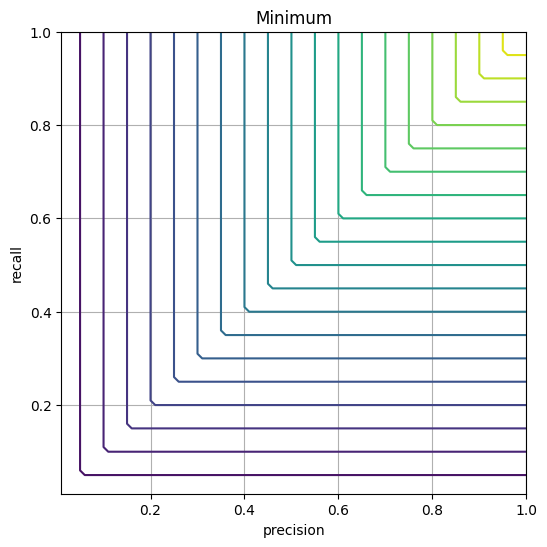

In [15]:
A, B = np.meshgrid(np.linspace(0.01, 1, 100), np.linspace(0.01, 1, 100))

min_levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        min_levels[i, j] = min([A[i, j], B[i, j]])

plt.figure(figsize=(6, 6))
plt.title('Minimum')
plt.xlabel('precision')
plt.ylabel('recall')
plt.grid()
plt.contour(A, B, min_levels, levels=20)

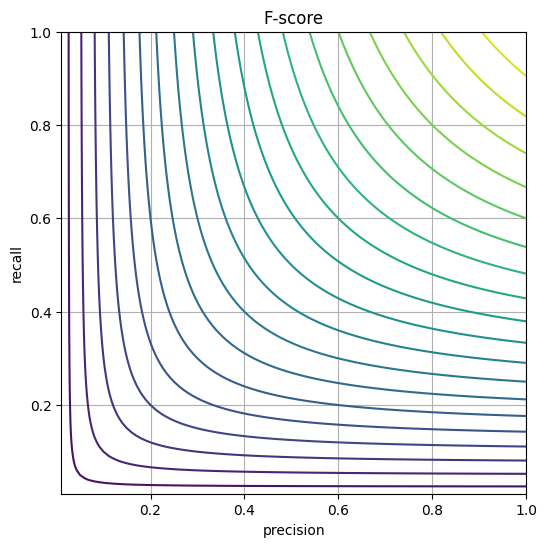

In [16]:
f_levels = np.empty_like(A)
b = 1
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        f_levels[i, j] = 2 * A[i, j] * B[i, j]*(1 + b **2) / (A[i, j]* (b**2) + B[i, j])

plt.figure(figsize=(6, 6))
plt.title('F-score')
plt.xlabel('precision')
plt.ylabel('recall')
plt.grid()
plt.contour(A, B, f_levels, levels=20)

Существует также усовершенствованная версия F-меры $F_{\beta}$:

$$F_{\beta} = (1 + \beta^{2}) \frac{precision \cdot recall}{\beta^{2} \cdot precision + recall}.$$

Параметр $\beta$ здесь определяет вес точности в метрике. При $\beta = 1$ это среднее гармоническое, умноженное на 2 (чтобы в случае $precision = 1$ и $recall = 1$ $F_{1} = 1$). Его изменение требуется, когда необходимо отдать приоритет точности или полноте, как это было показано в примерах ранее. Чтобы важнее была полнота, $\beta$ должно быть меньше 1, чтобы важнее была точность - больше.

In [17]:


%matplotlib inline

In [74]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss

In [19]:
import warnings

warnings.filterwarnings( "ignore")

Реализация логистической регрессии :

In [198]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

## SKlearn метрики

Модуль sklearn.metrics предоставляет набор простых функций, измеряющих ошибку предсказания с учетом истинности и предсказания:

  - функции, заканчивающиеся на, _score возвращают значение для максимизации, чем выше, тем лучше.
  - функции, заканчивающиеся на _error или _loss возвращающие значение, которое нужно минимизировать, чем ниже, тем лучше.
  

Некоторые из них ограничены случаем двоичной классификации:

  - precision_recall_curve(y_true, probas_pred, *)	Вычислите пары точности-полноты для разных пороговых значений вероятности.
  - roc_curve(y_true, y_score, *[, pos_label, …])	Вычислить рабочую характеристику приемника (ROC).

Другие работают в случае мультикласса:

  - balanced_accuracy_score(y_true, y_pred, *[, …])	Вычислите сбалансированную точность.
  - confusion_matrix(y_true, y_pred, *[, …])	Вычислите матрицу неточностей, чтобы оценить точность классификации.
  - roc_auc_score(y_true, y_score, *[, average, …])	Вычислить площадь под кривой рабочих характеристик приемника (ROC AUC) по оценкам прогнозов.

Работают универсально:

  - accuracy_score(y_true, y_pred, *[, …])	Классификационная оценка accuracy.
  - classification_report(y_true, y_pred, *[, …])	Создайте текстовый отчет, показывающий основные показатели классификации.
  - f1_score(y_true, y_pred, *[, labels, …])	Вычислите оценку F1, также известную как сбалансированная оценка F или F-мера.
  - fbeta_score(y_true, y_pred, *, beta[, …])	Вычислите оценку F-beta.

  - log_loss(y_true, y_pred, *[, eps, …]) кросс-энтропия или логистические потери.

  - multilabel_confusion_matrix(y_true, y_pred, *)	Вычислите матрицу неточностей для каждого класса или образца.
  - precision_recall_fscore_support(y_true, …)	Точность , полнота, F-мера и поддержка для каждого класса.
  - precision_score(y_true, y_pred, *[, labels, …])	Вычислите точность.
  - recall_score(y_true, y_pred, *[, labels, …])	Вычислите отзыв.
  - roc_auc_score(y_true, y_score, *[, average, …])	Вычислить площадь под кривой рабочих характеристик приемника (ROC AUC) по оценкам прогнозов.

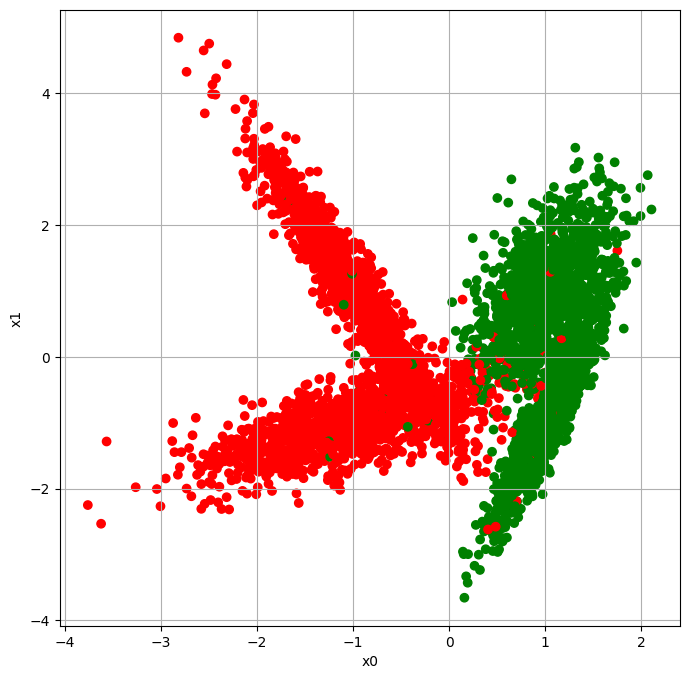

In [21]:
from sklearn import datasets
from matplotlib.colors import ListedColormap

# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=5000, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=110)
#

#classes = datasets.make_blobs(n_samples=1000,centers = 2, cluster_std = 1., random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue','green'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)
plt.grid()
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()


In [22]:
# разбиение данных на тренировочные и отложенную выборку (тестовые),
#где X, y - описание примеров и их целевое свойство (классы), а test_size=0.2 - пропорция разбиения (доля тестов)
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(classes[0], classes[1], test_size=0.2, random_state=1)
X_val_tr, X_test_tr, y_val_tr, y_test_tr = train_test_split(X_test_tr,  y_test_tr, test_size=0.5, random_state=1)

In [23]:
lr = LogisticRegression()
lr.fit(X_train_tr,y_train_tr)

y_pred = lr.predict_proba(X_val_tr)

Построим порог принятия решений из наблюдения за данными:
    х0 > tr

In [42]:
tr = 0.5
y_p = (y_pred[:,1] > tr).astype(int)
tr, accuracy_score((y_val_tr==1).astype('int'),y_p)

(0.5, 0.982)

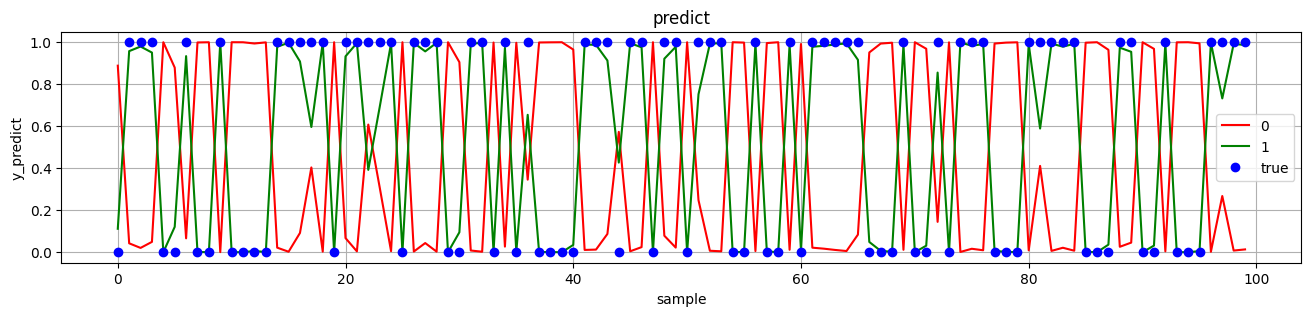

In [40]:
n = 100
plt.figure(figsize=(16,3))
plt.plot(y_pred[:n,0], 'r', label='0')
plt.plot(y_pred[:n,1], 'g', label='1')
plt.plot(y_val_tr[:n], 'ob', label='true')
plt.grid()
plt.title('predict')
plt.xlabel('sample')
plt.ylabel('y_predict')
plt.legend()
plt.show()


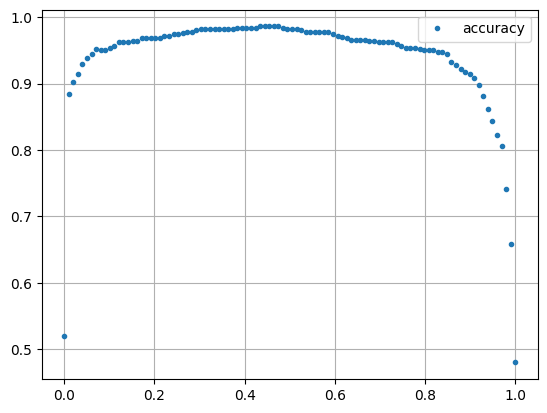

In [43]:
acc = []
y_min = y_p.min()
y_max = y_p.max()
for tr in np.linspace(y_min,y_max,100):

    y_p = (y_pred[:,1] > tr).astype(int)
    acc += [[tr,accuracy_score((y_val_tr==1).astype('int'),y_p)]]
    # print(acc[-1][0],acc[-1][1])
acc = np.array(acc)
plt.plot(acc[:,0],acc[:,1],'.',label = 'accuracy')
plt.grid()
plt.legend()
plt.show()

тестовое множество:

In [137]:
y_pred = lr.predict_proba(X_test_tr)[:,1]
y_p = (y_pred[:] > 0.45).astype(int)
accuracy_score(y_test_tr,y_p)

0.978

### **Задание 1.**

1.1 Добавьте собственную реализацию вычисления Accuracy

1.2 определите лучший уровень значений Accuracy для текущего примера

1.3 определите уровень Accuracy по тестовой выборке на лучшем по тренировояной уровне оценки

1.4 Оцените (постройте кривые изменения Accuracy и потерь для тестовой(отложенной выборки) ) поведение модели при использовании одной и 2-х координат (х0,х1)

1.5  зафиксируйте результаты в таблице и сделайте выводы

In [128]:
# 1.1
def accuracy_score_my(y, y_p):
    n = y.shape[0]
    return np.sum(y == y_p) / n

accuracy_score_my(y_test_tr, y_p)

0.978

In [138]:
# 1.2
def get_best_tr_and_accuracy(y_test_tr, y_pred, n_points=1000):
    best_tr, best_accuracy = 0, -np.inf
    for tr in np.linspace(0, 1, n_points):
        y_p = (y_pred > tr).astype(int)
        cur_accuracy = accuracy_score_my(y_test_tr, y_p)
        if cur_accuracy > best_accuracy:
            best_accuracy = cur_accuracy
            best_tr = tr
    return best_tr, best_accuracy

best_tr, best_accuracy = get_best_tr_and_accuracy(y_test_tr, y_pred)

print(f'best accuracy {best_accuracy} with threshold {best_tr:.4f}')

best accuracy 0.982 with threshold 0.5235


In [130]:
# 1.3
y_pred_valid = lr.predict_proba(X_val_tr)[:, 1]
y_p_valid = (y_pred_valid > best_tr)
best_accuracy_valid = accuracy_score_my(y_val_tr, y_p_valid)
best_accuracy_valid

0.98

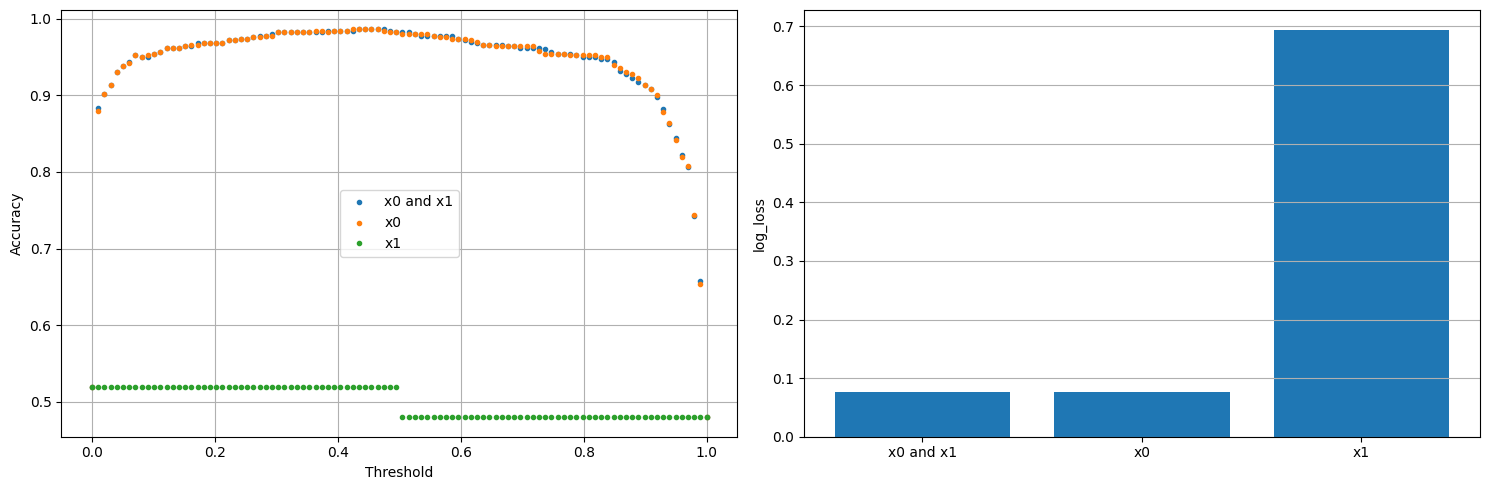

loss: 0.0761
loss_x0: 0.0762
loss_x1: 0.6934


In [131]:
# 1.4
y_pred = lr.predict_proba(X_val_tr)[:, 1]

lr_x0 = LogisticRegression()
lr_x0.fit(X_train_tr[:, 0].reshape(-1, 1), y_train_tr)
y_pred_x0 = lr_x0.predict_proba(X_val_tr[:, 0].reshape(-1, 1))[:, 1]

lr_x1 = LogisticRegression()
lr_x1.fit(X_train_tr[:, 1].reshape(-1, 1), y_train_tr)
y_pred_x1 = lr_x1.predict_proba(X_val_tr[:, 1].reshape(-1, 1))[:, 1]

acc_x0 = []
acc_x1 = []

for tr in np.linspace(y_min, y_max, 100):
    y_p_x0 = (y_pred_x0 > tr)
    acc_x0.append([tr, accuracy_score_my(y_val_tr, y_p_x0)])
    
    y_p_x1 = (y_pred_x1 > tr)
    acc_x1.append([tr, accuracy_score_my(y_val_tr, y_p_x1)])

acc_x0 = np.array(acc_x0)
acc_x1 = np.array(acc_x1)

loss = log_loss(y_val_tr, y_pred)
loss_x0 = log_loss(y_val_tr, y_pred_x0)
loss_x1 = log_loss(y_val_tr, y_pred_x1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(acc[:, 0], acc[:, 1], '.', label='x0 and x1')
ax1.plot(acc_x0[:, 0], acc_x0[:, 1], '.', label='x0')
ax1.plot(acc_x1[:, 0], acc_x1[:, 1], '.', label='x1')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy')
ax1.grid()
ax1.legend()

models = ['x0 and x1', 'x0', 'x1']
losses = [loss, loss_x0, loss_x1]

ax2.bar(models, losses)
ax2.set_ylabel('log_loss')
ax2.grid(axis='y')

plt.tight_layout()
plt.show()

print(f"loss: {loss:.4f}")
print(f"loss_x0: {loss_x0:.4f}")
print(f"loss_x1: {loss_x1:.4f}")

In [132]:
# 1.5
best_tr_x0, best_accuracy_x0 = get_best_tr_and_accuracy(y_val_tr, y_pred_x0)
best_tr_x1, best_accuracy_x1 = get_best_tr_and_accuracy(y_val_tr, y_pred_x1)

results_table = pd.DataFrame({
    'model': ['x0 and x1', 'x0', 'x1'],
    'log_loss': [loss, loss_x0, loss_x1],
    'best accuracy': [best_accuracy, best_accuracy_x0, best_accuracy_x1],
    'best threshold': [best_tr, best_tr_x0, best_tr_x1]
})
results_table

,model,log_loss,best accuracy,best threshold
0,x0 and x1,0.076093,0.982,0.523524
1,x0,0.076158,0.986,0.422422
2,x1,0.693410,0.540,0.496496


Выводы по таблице
- Признак x0 содержит всю ключевую информацию
- Признак x1 не несёт в себе полезной информации или является шумом, его добавление даже ухудшает accuracy
- Модель с одним признаком x0 наилучшая


Для хранения наборов данных scikit learn  :
  - использует массивы в формате numpy.array ( из библиотеки NymPy)
  - использует разреженные матрицы в формате scipy.sparse (из библиотеки SciPy)
  - поддерживает формат хранения DataFrame из библиотеки Pandas
  - имеет функции, позволяющие считывать данные из внешних файлов в форматах txt, csv, json и так далее.
  - использует наборы данных, которые поставляются вместе с библиотекой. Это открытые общеизвестные данные:
      - **данные о стоимости жилья в Калифорнии**: исходя из количества комнат и уровня преступности в городе, модель может вычислять цены на жилье;
      - **данные о результатах диагностики рака молочных желез** из города Висконсина: используются для выявления злокачественного или доброкачественного новообразования;
      - **датасет химических свойств вин**: исходя из этих свойств модель может определить тип вина.
      
      
### **Задание 2.**


1.0. Загрузить набор **стоимость жилья в Калифорнии** (или любой похожий).


1.1  Проведите эксперимент(для кода из результата задания 1) с изменением шага по  порогу в диапазоне (0.001, 0.1) (10 вариантов) по всеп признакам численного типа

1.2  зафиксируйте результаты в таблице и сделайте выводы


In [124]:
# 1.0
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing.data
y = (housing.target > np.median(housing.target)).astype(int)
np.unique(y)

array([0, 1])

Стоит отметить, что таргет в датасете – вещественное число, поэтому рассмотрим следующую задачу классификации:
будем считать, что y – дорогое жильё, если его цена превосходит медиану цен всей недвижимости в датасете. В противном
случае y – недорогое жильё. Дорогому жилью соответствует метка 1, а недорогому – 0.

In [150]:
# 1.1
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X, y, test_size=0.3, random_state=42)

y.shape
lr_housing = LogisticRegression()
lr_housing.fit(X_train_h, y_train_h)
y_pred = lr_housing.predict_proba(X_test_h)[:, 1]

steps = np.linspace(0.001, 0.1, 10)
res = []
for step in steps:
    n_points = int(1 / step) + 1
    best_tr, best_accuracy = get_best_tr_and_accuracy(y_test_h, y_pred, n_points)
    res.append([step, best_tr, best_accuracy])

res = np.array(res)
max_idx = res[:, 2].argmax()
print(f'best step: {res[max_idx, 0]}')
print(f'best threshold: {res[max_idx, 1]}')
print(f'best accuracy: {res[max_idx, 2]}')

best step: 0.001
best threshold: 0.488
best accuracy: 0.7960271317829457


In [172]:
# 1.2
results_table = pd.DataFrame({
    'step': res[:, 0],
    'threshold': res[:, 1],
    'accuracy': res[:, 2]
})
results_table

,step,threshold,accuracy
0,0.001,0.488000,0.796027
1,0.012,0.481928,0.795220
2,0.023,0.488372,0.795704
3,0.034,0.482759,0.794735
4,0.045,0.500000,0.795704
5,0.056,0.470588,0.794897
6,0.067,0.500000,0.795704
7,0.078,0.500000,0.795704
8,0.089,0.454545,0.793120
9,0.100,0.500000,0.795704


Выводы: шаг не повлиял на поиск threshold для наилучшего accuracy. Для всех шагов accuracy примерно одинаковый

#### Сформируем отчет о классификации для сгенерированного датасета 

In [165]:
lr = LogisticRegression()
lr.fit(X_train_tr, y_train_tr)

y_pred = lr.predict_proba(X_test_tr)[:, 1]
y_p = (y_pred > 0.5)

print(classification_report(y_test_tr, y_p))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       248
           1       0.97      1.00      0.98       252

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



Проведем эксперимент для нескольких перезапусков алгоритма (К) и различных сочетаний значений гиперпараметров (tol, max_iter). Сделаем сеточный поиск в пространстве вариантов для множества К = 10 реализаций

In [171]:
import seaborn as sns
from sklearn.model_selection import GridSearchCV

param_grid = {
    'tol': [1e-4, 1e-3, 1e-2],
    'max_iter': [50, 100, 200, 500, 1000]
}

K = 10
results = []

for k in range(K):
    lr = LogisticRegression(random_state=k)
    grid_search = GridSearchCV(
        lr, 
        param_grid, 
        cv=5, 
        scoring='accuracy'
    )
    
    grid_search.fit(X_train_tr, y_train_tr)
    
    results.append({
        'run': k,
        'tol': grid_search.best_params_['tol'],
        'max_iter': grid_search.best_params_['max_iter'],
        'score': grid_search.score(X_test_tr, y_test_tr)
    })

results_df = pd.DataFrame(results)
results_df

,run,tol,max_iter,score
0,0,0.0001,50,0.98
1,1,0.0001,50,0.98
2,2,0.0001,50,0.98
3,3,0.0001,50,0.98
4,4,0.0001,50,0.98
5,5,0.0001,50,0.98
6,6,0.0001,50,0.98
7,7,0.0001,50,0.98
8,8,0.0001,50,0.98
9,9,0.0001,50,0.98


Вывод: необходимо 50 итераций tol = 0.0001. Выборка примеров сбалансирована, и применение метрик типа accuracy обосновано.

### **Задание 3.**

Построить последовательность обработки примеров для набора "Ирисы Фишера"(load_iris):
 - провести генерацию порогового классификатора
 - провести анализ результата (см. пример)

In [194]:
data = load_iris()
X, y = data.data, data.target
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(X, y, test_size=0.2, random_state=1)

param_grid = {
    'tol': [1e-4, 1e-3, 1e-2],
    'max_iter': [50, 100, 200, 500, 1000]
}

lr = LogisticRegression(random_state=1)
grid_search = GridSearchCV(
    lr, 
    param_grid, 
    cv=5, 
    scoring='accuracy'
)

grid_search.fit(X_train_tr, y_train_tr)
best_tol = grid_search.best_params_['tol']
best_max_iter = grid_search.best_params_['max_iter']
print(f'best tol: {best_tol}, best max_iter: {best_max_iter}')
print(f'accuracy: {grid_search.score(X_test_tr, y_test_tr)}')

best tol: 0.01, best max_iter: 50
accuracy: 0.9666666666666667


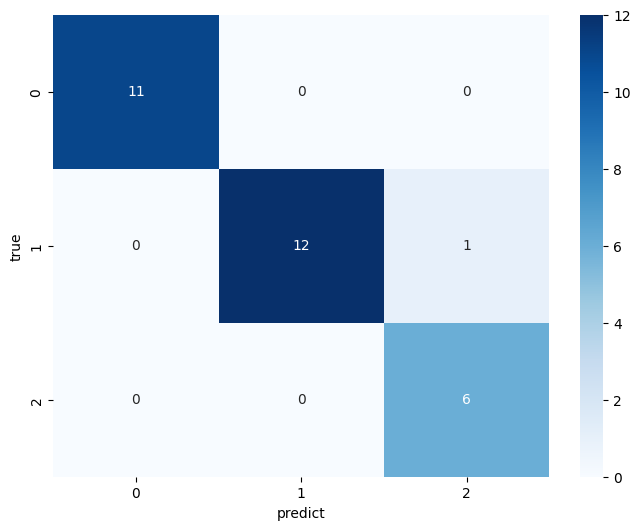

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.92      0.96        13
           2       0.86      1.00      0.92         6

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



In [201]:
y_p = grid_search.predict(X_test_tr)

cm = confusion_matrix(y_test_tr, y_p)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('true')
plt.xlabel('predict')
plt.show()

print(classification_report(y_test_tr, y_p))

### **Задание 4.**

Самостоятельно оценить данные по варианту:


In [202]:
# вариант 11 => 11 % 5 = 1
V1 = datasets.load_wine()
V2 = datasets.load_digits()
V3 = datasets.load_breast_cancer()
V4 = datasets.make_classification(n_samples = 1000, n_features=10, n_redundant=2, n_informative=2,random_state=10, n_clusters_per_class=2)
V5 = datasets.make_blobs(n_samples=1000, centers=2, n_features=5, random_state=10)

3.1.Загрузить данные  по варианту

3.2. Провести формирование классификатора для набора по своему варианту

3.3. Определить вид метрики , который соответствует степени сбалансированности набора данных

3.4. Сравнить варианты классификатора по метрике.

3.5. Cделать выводы о качестве для модели из задания 1 и sklearn на основе выбранной метрики

3.6 Сделать выводы о качестве модели

In [208]:
# 3.1
X, y = V1.data, V1.target
df_x = pd.DataFrame(X)
np.unique(y)

array([0, 1, 2])

In [230]:
# 3.2
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'tol': [1e-4, 1e-3, 1e-2],
    'max_iter': [50, 100, 200, 500, 1000]
}

lr = LogisticRegression(random_state=42)
grid_search = GridSearchCV(
    lr, 
    param_grid, 
    cv=5, 
    scoring='accuracy'
)

grid_search.fit(X_train_tr, y_train_tr)
log_reg = grid_search.best_estimator_

In [231]:
# 3.3
class_counts = np.bincount(y)
imbalance_ratio = max(class_counts) / min(class_counts)
imbalance_ratio

1.4791666666666667

Для imbalance_ratio <= 1.5 хорошо подойдёт accuracy, т.к. при данных значениях imbalance_ratio,
классы таргета явлюятся сбалансированными. F1 также подойдёт.

In [232]:
# 3.4
classifiers = {
    'Logistic Regression': log_reg,
    'Random Forest': RandomForestClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

results = []

for model_name, model in classifiers.items():
    model.fit(X_train_tr, y_train_tr)
    y_p = model.predict(X_test_tr)
    model_accuracy = accuracy_score(y_test_tr, y_p)
    results.append({
        'classifier': model_name,
        'accuracy': model_accuracy
    })

results_df = pd.DataFrame(results)
results_df

,classifier,accuracy
0,Logistic Regression,0.981481
1,Random Forest,1.000000
2,K-Nearest Neighbors,0.740741
3,Naive Bayes,1.000000


3.5

Модель из задания 1 имеет accuracy = 0.982, что является отличным показателем. Для датасета с винами лучше всего себя показал
Random Forest и наивный байес, которые имеют accuracy = 1. Т.к. датасет с винами достаточно мал, то закономерно, что
эти модели смогли точно предсказать метки для всех объектов.

3.6
Модель Logistic Regression имеет качество примерно такое же, как для задания 1, то есть высокое. 
Наихудшее качество имеет k ближайших соседей, т.к. KNN плохо работает в пространстве с большим числом признаков, 
а датасет с винами имеет 13 признаков. А также признаки имеют разный масштаб